In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torchcox import TorchCox

import numpy as np
import torch
import pandas as pd

In [3]:
df_tied = pd.read_csv('../data/ovarian_deduplicated.csv')
df_tied

,tyears,d,Karn,Broders,FIGO,Ascites,Diam,id
0,0.024657,1,8,2.0,IV,1,1-2cm,281
1,0.027398,1,6,NaN,IV,1,>5cm,298
2,0.035617,1,8,2.0,IV,1,>5cm,342
3,0.041094,1,7,2.0,III,0,<1cm,228
4,0.082192,1,7,3.0,IV,1,<1cm,52
...,...,...,...,...,...,...,...,...
299,7.060274,0,10,3.0,III,0,>5cm,101
300,7.112330,0,10,1.0,III,1,>5cm,93
301,7.120548,0,9,2.0,III,1,<1cm,40
302,7.290410,0,9,2.0,IV,1,1-2cm,81


In [4]:
valdf = pd.DataFrame({'id':['Bob','Sally','James','Ann'], 'time':[1,3,6,10], 'status':[1,1,0,1], 'smoke':[1,0,0,1]})
valdf

,id,time,status,smoke
0,Bob,1,1,1
1,Sally,3,1,0
2,James,6,0,0
3,Ann,10,1,1


In [5]:
tname = 'time'
Xnames = ['smoke']
dname = 'status'

coxmod1 = TorchCox.TorchCox(lr=1)

coxmod1.fit(valdf, Xnames=Xnames, tname=tname, dname=dname)

coxmod1.beta.detach().numpy()[0]

[0.34657338]


0.34657338

MLE of Cox model on simple dataset above has closed-form solution, which is ln(2)/2. The result above should equal this, which reassuringly it does.

In [6]:
np.log(2)/2

0.34657359027997264

Now we will compare our result against the R package 'survival' on another dataset.

In [7]:
coxmod = TorchCox.TorchCox()

tname = 'tyears'
Xnames = ['Karn', 'Ascites']
dname = 'd'

In [8]:
%load_ext rpy2.ipython

In [9]:
%%R
library(readr)
library(survival)
library(dplyr)
library(tidyr)

df2 = read_csv("/home/ilan/Desktop/TorchCox/data/ovarian_deduplicated.csv")

#df2 = df2 %>% arrange(tyears)

starttime = Sys.time()

rmod = coxph(Surv(tyears, d) ~ Karn + Ascites, df2, ties="breslow")
print(coef(rmod))

endtime = Sys.time()

print(endtime-starttime)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Parsed with column specification:
cols(
  tyears = col_double(),
  d = col_double(),
  Karn = col_double(),
  Broders = col_double(),
  FIGO = col_character(),
  Ascites = col_double(),
  Diam = col_character(),
  id = col_double()
)



      Karn    Ascites 
-0.2364006  0.4170308 
Time difference of 0.02901912 secs


In [10]:
%%time

coxmod.fit(df_tied, Xnames=Xnames, tname=tname, dname=dname, basehaz=False)

[-0.23638311  0.4170416 ]
CPU times: user 895 ms, sys: 3.37 ms, total: 899 ms
Wall time: 262 ms


We indeed match that result as well!  
We are about 10x slower than the R package (which runs in C). But simplicity and extensibility of our code compensates for that in my view. Also timings here most likely dominated by overhead of loading libraries, comparison on larger dataset required.

Fit again, but this time computing the baseline hazard, to ensure that works as well.

In [11]:
%%time

coxmod.fit(df_tied, Xnames=Xnames, tname=tname, dname=dname, basehaz=True)

[-0.23638311  0.4170416 ]
CPU times: user 2.34 s, sys: 108 ms, total: 2.45 s
Wall time: 1.72 s


In [12]:
coxmod.basehaz

,time,h0,H0
0,0.024657240259862743,0.018764267,0.018764267
1,0.02739761676265909,0.018845245,0.0376095
2,0.03561695837826295,0.018976642,0.0565862
3,0.04109387045962334,0.019059468,0.0756456
4,0.08219248033739741,0.019129159,0.0947748
...,...,...,...
299,7.0602742018236055,1.4441799,28.2556
300,7.112329818483311,1.671192,29.9268
301,7.120547803885543,2.1946971,32.1215
302,7.290409766965798,3.6383288,35.7598


Predict on the training set to ensure predict_proba() method works as well.

In [14]:
df_tied['pred'] = coxmod.predict_proba(df_tied, Xnames=Xnames, tname=tname)
df_tied

,tyears,d,Karn,Broders,FIGO,Ascites,Diam,id,pred
0,0.024657,1,8,2.0,IV,1,1-2cm,281,0.995712
1,0.027398,1,6,NaN,IV,1,>5cm,298,0.986277
2,0.035617,1,8,2.0,IV,1,>5cm,342,0.987125
3,0.041094,1,7,2.0,III,0,<1cm,228,0.985644
4,0.082192,1,7,3.0,IV,1,<1cm,52,0.972883
...,...,...,...,...,...,...,...,...,...
299,7.060274,0,10,3.0,III,0,>5cm,101,0.070109
300,7.112330,0,10,1.0,III,1,>5cm,93,0.013961
301,7.120548,0,9,2.0,III,1,<1cm,40,0.003005
302,7.290410,0,9,2.0,IV,1,1-2cm,81,0.001557


Fit ROC on training set, only to ensure we are doing better than random. This should be the C-index but will do that later.

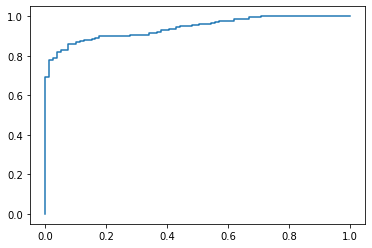

In [15]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(df_tied[dname].values, df_tied['pred'].values, pos_label=1)

plt.plot(fpr, tpr)

In [16]:
metrics.auc(fpr, tpr)

0.94070323488045

See section 5.1 of this paper for possible choices of performance metric to use:  
https://arxiv.org/abs/1912.08581  
https://arxiv.org/pdf/2012.04284.pdf

A plot just showing how the non-zero entries of the tensor we created get more sparse as the unique event time increases.

In [17]:
#tname = 'tyears'
#Xnames = ['Karn', 'Ascites']
#dname = 'd'

tname = 'time'
Xnames = ['smoke']
dname = 'status'


def padToMatch2d(inputtens, targetshape):
    target = torch.zeros(*targetshape)
    target[:inputtens.shape[0], :inputtens.shape[1]] = inputtens
    return target

#tensin = torch.from_numpy(df_tied[[tname,dname,*Xnames]].values)
tensin = torch.from_numpy(valdf[[tname,dname,*Xnames]].values)

        #Get unique event times
tensin_events = torch.unique(tensin[tensin[:,1]==1, 0])

        #For each unique event stack another matrix with event at the top, and all at risk entries below
tensor = torch.stack([padToMatch2d(tensin[tensin[:,0] >= eventtime, :], tensin.shape) for eventtime in tensin_events])

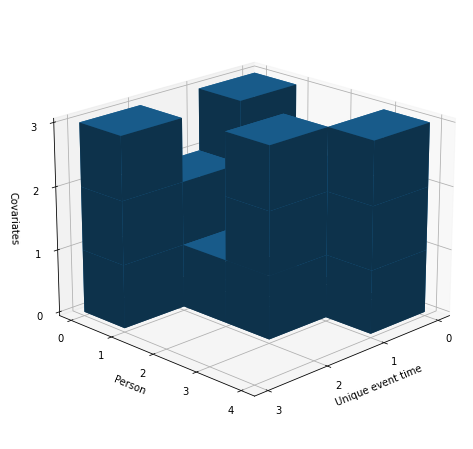

In [18]:
# https://stackoverflow.com/a/44830397

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20., azim=45)

ax.set_xlabel('Unique event time')
ax.set_ylabel('Person')
ax.set_zlabel('Covariates')

#Integer tick marks only
#https://stackoverflow.com/questions/12050393/how-to-force-the-y-axis-to-only-use-integers-in-matplotlib#comment110460128_38096332
ax.xaxis.get_major_locator().set_params(integer=True)
ax.yaxis.get_major_locator().set_params(integer=True)
ax.zaxis.get_major_locator().set_params(integer=True)

voxels = (tensor != 0).numpy()

ax.voxels(voxels)

plt.show()

In [19]:
tensor

tensor([[[ 1.,  1.,  1.],
         [ 3.,  1.,  0.],
         [ 6.,  0.,  0.],
         [10.,  1.,  1.]],

        [[ 3.,  1.,  0.],
         [ 6.,  0.,  0.],
         [10.,  1.,  1.],
         [ 0.,  0.,  0.]],

        [[10.,  1.,  1.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]])